# Deterministic vs Stochastic SIR Model with Varying Beta

In this notebook, we compare **Deterministic** and **Stochastic** implementations of the SIR (Susceptible-Infectious-Recovered) model across different transmission rates (Beta).

## Mathematical Model (Discrete Time)

The model is defined by the following system of difference equations:

$$
\begin{aligned}
S(t+1) &= S(t) - \beta S(t) I(t) \\
I(t+1) &= I(t) + \beta S(t) I(t) - \mu I(t) \\
R(t+1) &= R(t) + \mu I(t)
\end{aligned}
$$

Where:
- $S(t), I(t), R(t)$: Proportions of Susceptible, Infectious, and Recovered individuals.
- $\beta$: Infection rate.
- $\mu$: Recovery rate.

### Deterministic Approach
Solves the equations exactly. Represents the average behavior of an infinite population.

### Stochastic Approach
Simulates individual probabilities of infection and recovery in a finite population ($N$). Captures randomness and variability.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

## 1. Simulation Functions

In [2]:
def run_deterministic(beta, mu, T_max, I0_prop=0.01):
    S0 = 1 - I0_prop
    R0 = 0
    
    S_hist = [S0]
    I_hist = [I0_prop]
    R_hist = [R0]
    
    for t in range(T_max):
        St, It, Rt = S_hist[-1], I_hist[-1], R_hist[-1]
        
        # Deterministic updates
        new_infections = beta * St * It
        new_recoveries = mu * It
        
        next_S = St - new_infections
        next_I = It + new_infections - new_recoveries
        next_R = Rt + new_recoveries
        
        S_hist.append(next_S)
        I_hist.append(next_I)
        R_hist.append(next_R)
        
    return np.array(S_hist), np.array(I_hist), np.array(R_hist)

def run_stochastic(N, beta, mu, T_max, I0_prop=0.01):
    I = int(I0_prop * N)
    S = N - I
    R = 0
    
    S_hist, I_hist, R_hist = [S], [I], [R]
    
    for t in range(T_max):
        # Probability of infection
        p_inf = beta * I / N
        p_inf = min(max(p_inf, 0), 1)
        
        # Random events
        new_infections = np.random.binomial(S, p_inf)
        new_recoveries = np.random.binomial(I, mu)
        
        S = S - new_infections
        I = I + new_infections - new_recoveries
        R = R + new_recoveries
        
        S, I, R = max(S, 0), max(I, 0), max(R, 0)
        
        S_hist.append(S)
        I_hist.append(I)
        R_hist.append(R)
        
    return np.array(S_hist)/N, np.array(I_hist)/N, np.array(R_hist)/N

## 2. Running Simulations (Varying Beta)

In [3]:
betas = [0.25, 0.40, 0.55, 0.70, 0.85]
mu = 0.1
T_max = 100
N = 1000

results_det = {}
results_stoch = {}

for b in betas:
    results_det[b] = run_deterministic(b, mu, T_max)
    # Run a single realization for stochastic plotting
    results_stoch[b] = run_stochastic(N, b, mu, T_max)

## 3. Visualization

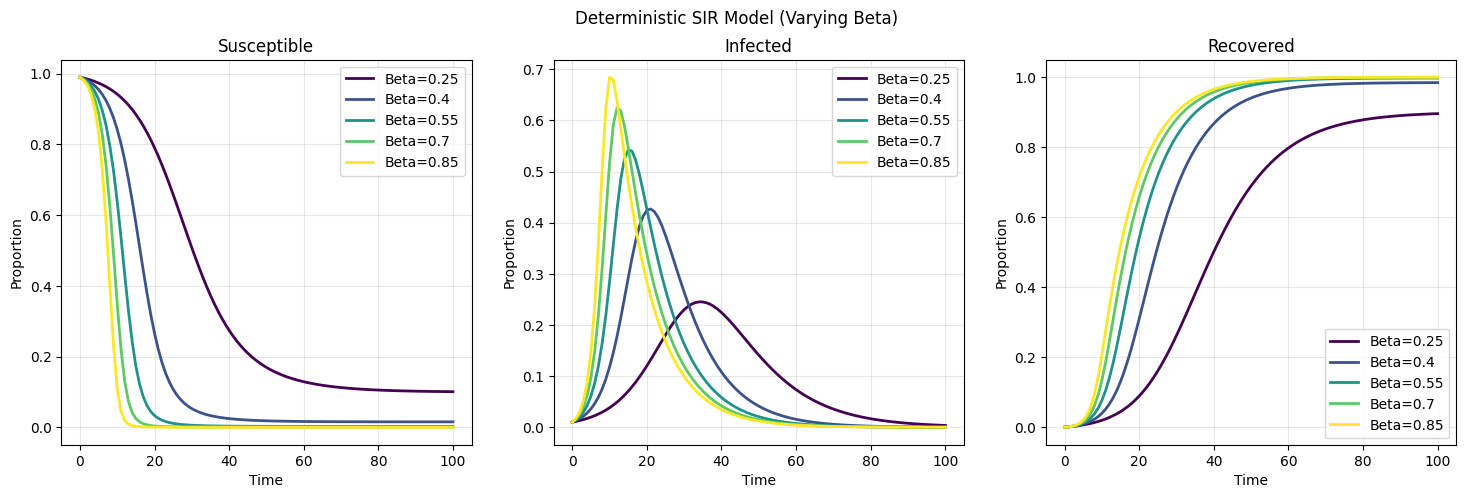

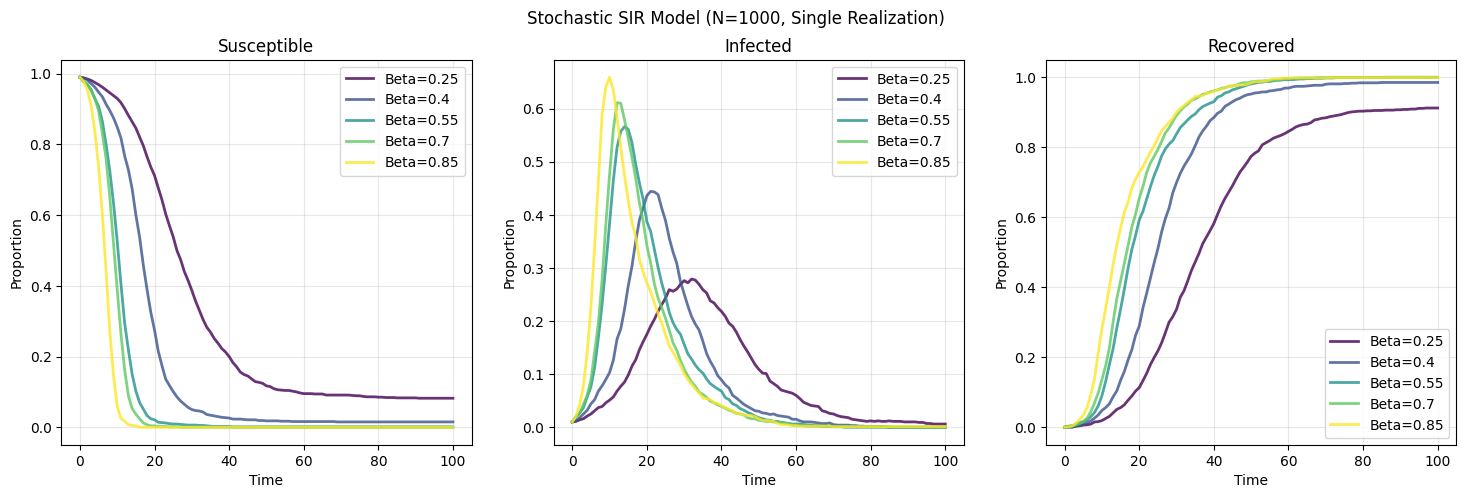

In [4]:
t_grid = range(T_max + 1)
colors = plt.cm.viridis(np.linspace(0, 1, len(betas)))

# --- Deterministic Plot ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Deterministic SIR Model (Varying Beta)")

for i, b in enumerate(betas):
    S, I, R = results_det[b]
    axes[0].plot(t_grid, S, label=f'Beta={b}', color=colors[i], lw=2)
    axes[1].plot(t_grid, I, label=f'Beta={b}', color=colors[i], lw=2)
    axes[2].plot(t_grid, R, label=f'Beta={b}', color=colors[i], lw=2)

axes[0].set_title("Susceptible")
axes[1].set_title("Infected")
axes[2].set_title("Recovered")

for ax in axes:
    ax.set_xlabel("Time")
    ax.set_ylabel("Proportion")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.show()

# --- Stochastic Plot ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle(f"Stochastic SIR Model (N={N}, Single Realization)")

for i, b in enumerate(betas):
    S, I, R = results_stoch[b]
    axes[0].plot(t_grid, S, label=f'Beta={b}', color=colors[i], lw=2, alpha=0.8)
    axes[1].plot(t_grid, I, label=f'Beta={b}', color=colors[i], lw=2, alpha=0.8)
    axes[2].plot(t_grid, R, label=f'Beta={b}', color=colors[i], lw=2, alpha=0.8)

axes[0].set_title("Susceptible")
axes[1].set_title("Infected")
axes[2].set_title("Recovered")

for ax in axes:
    ax.set_xlabel("Time")
    ax.set_ylabel("Proportion")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.show()

## Herd Immunity Check

In [8]:
print(f"{'Beta':<10} {'R0 (Basic Rep Number)':<25} {'Simulated Final Size':<25} {'Theoretical Final Size'}")
print("-" * 85)

for b in betas:
    # 1. Get Simulated Final Size (R at last step)
    simulated_final_R = results_det[b][2][-1]
    
    # 2. Calculate Basic Reproduction Number R0
    R0_val = b / mu
    
    # 3. Solve for Theoretical Final Size (R_inf)
    # Equation: 1 - R_inf - S0 * exp(-R0 * R_inf) = 0   (assuming I0 ~ 0)
    # Or more precisely: S_inf = S0 * exp(-R0 * (R_inf))
    # And R_inf = 1 - S_inf  (assuming I_inf = 0)
    
    def final_size_eq(r_inf):
        # S_inf = 1 - r_inf
        # Equation derived from dS/dR = -S * (beta/mu) -> ln(S/S0) = - (beta/mu) * (R - R0)
        # S_inf = S0 * exp(-R0_val * (r_inf - 0))
        # r_inf = 1 - S_inf 
        # -> r_inf = 1 - S0 * exp(-R0_val * r_inf)
        s0_val = 1 - 0.01 # Initial S
        return r_inf - (1 - s0_val * np.exp(-R0_val * r_inf))
    
    # Solve numerically
    theoretical_final_R = fsolve(final_size_eq, 0.5)[0]
    
    print(f"{b:<10.2f} {R0_val:<25.2f} {simulated_final_R:<25.4f} {theoretical_final_R:.4f}")

Beta       R0 (Basic Rep Number)     Simulated Final Size      Theoretical Final Size
-------------------------------------------------------------------------------------
0.25       2.50                      0.8959                    0.8941
0.40       4.00                      0.9845                    0.9804
0.55       5.50                      0.9977                    0.9959
0.70       7.00                      0.9997                    0.9991
0.85       8.50                      0.9999                    0.9998


## 5. Visual Spread Representation (Calls external file)

In [9]:
# Going to simulate the SIR model visually and output as a GIF
# Stochastic SIR model

import SIRVisual
import networkx as nx

# CLI parameters (best for visualization)
num_nodes = 100
beta = 0.1
mu = 0.1
num_steps = 100


#execute the model
er_graph = nx.erdos_renyi_graph(num_nodes, 0.1) # 0.05 probability for connectivity
SIRVisual.visualize_sir(er_graph, "ER_Graph", beta, mu, num_steps)

[INFO] Visualizing ER_Graph (Beta=0.1, Gamma=0.1)
[INFO] Initial patient zero: 7


Simulating SIR on ER_Graph:  65%|██████▌   | 65/100 [00:16<00:08,  4.04it/s]

[INFO] Epidemic ended at step 66
[INFO] Creating GIF...


[INFO] GIF saved as 'output\ER_Graph_SIR_animation.gif'
[INFO] Frames directory deleted.


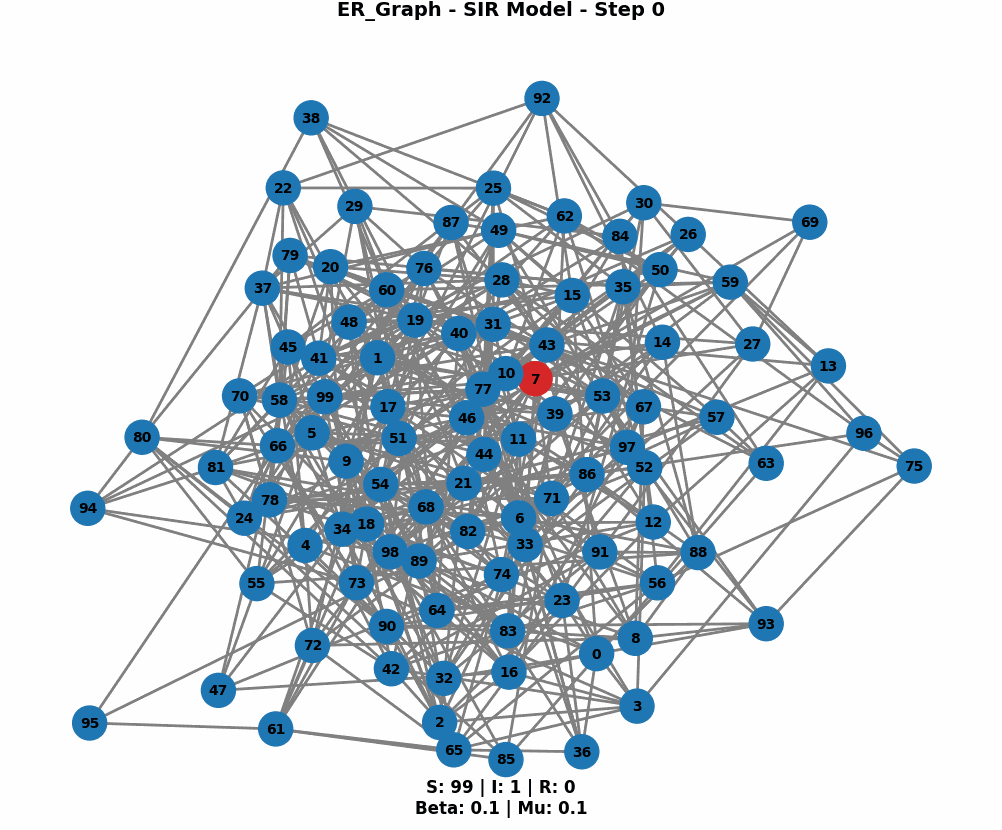

In [10]:
from IPython.display import Image, display
display(Image(filename="output/ER_Graph_SIR_animation.gif"))